# Growth rates and calibration for 3C-SiC physical vapor deposition

In the present notebook we implement the full workflow for the calibration of a Kinetic Monte Carlo (KMC) simulation with MulSKIPS of a physical vapor deposition (PVD) process for the epitaxial growth of cubic silicon carbide (3C-SiC). The workflow contains the following steps:

1. Growth rate extimation from the experimental gas vapor pressures;

2. Generation of the input file `start.dat` for the simulation of the PVD epitaxial growth with the KMC mulskips code;

3. Run the mulskips simulation in a predefined folder;

4. Analysis of crystalline quality of the epitaxial-growth substrate and the eventual epitaxial defects;

5. Growth rate extraction from the KMC mulskips run.

## Growth rate extimation from the gas vapor pressures at the source and seed chamber regions

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os,shutil,subprocess,sys
import py3Dmol

In [2]:
# Some constants related to the gas phase
Rgas = 8.314462618       # Gas constant J/mol/K
NA = 6.02214076e23       # Avogadro Number [mol^-1]
kb_ev=8.617333262145e-5     # [eV/K]
T_zero_kelvin = 273.15

# Some constants related to the gas-phase molecules
M_Si = 0.0280855 # [kg/mol]
M_SiC =  0.0280855 + 0.0120107 # [kg/mol]
M_Si2C = 2*0.0280855 + 0.0120107 # [kg/mol]
M_SiC2 = 0.0280855 + 2*0.0120107 # [kg/mol]
molecules = ['Si', 'Si2C', 'SiC2']
mass = {'Si': M_Si, 'Si2C': M_Si2C, 'SiC2': M_SiC2}

# Some constants related to the solid growing substrate
rho_SiC = 3210 # kg/m^3
a0 = pow(4*M_SiC/NA/rho_SiC,1.0/3.0) # [m] side of the cubic conventional cell of 3C-SiC containing four Si-C dimers
rho_surf_SiC = rho_SiC * a0 # Kg/m^2

In [3]:
# Data extracted from the excel file from Peter Wellmann "Temperature vs Growth rate.xlsx" 21 Oct 2020
# Old sight glass: wrong temperatures!!!
#data_samples = {}
#data_samples['151'] = {'Power': 5.45, 'T_seed_middle': 1880.00, 'T_seed_edge': 1883.51, 'T_source_middle': 1887.63, 'T_source_edge': 1886.94, 'Exp-Growth-Rate': 101}
#data_samples['148'] = {'Power': 5.85, 'T_seed_middle': 1933.26, 'T_seed_edge': 1936.73, 'T_source_middle': 1940.95, 'T_source_edge': 1940.29, 'Exp-Growth-Rate': 208}
#data_samples['149'] = {'Power': 5.90, 'T_seed_middle': 1939.64, 'T_seed_edge': 1943.10, 'T_source_middle': 1947.34, 'T_source_edge': 1946.68, 'Exp-Growth-Rate': 230}
#data_samples['152'] = {'Power': 6.00, 'T_seed_middle': 1952.39, 'T_seed_edge': 1955.84, 'T_source_middle': 1960.10, 'T_source_edge': 1959.45, 'Exp-Growth-Rate': 231}
#data_samples['153'] = {'Power': 6.10, 'T_seed_middle': 1964.78, 'T_seed_edge': 1968.22, 'T_source_middle': 1972.50, 'T_source_edge': 1971.85, 'Exp-Growth-Rate': 287}

In [4]:
# Data extracted from the excel file from Peter Wellmann "Temperature vs Growth rate.xlsx" 25 November 2020
# New sight glass
data_samples = {}
data_samples['151'] = {'Power': 5.45, 'T_seed_middle': 1986.26, 'T_seed_edge': 0, 'T_source_middle': 1994.14, 'T_source_edge': 1994.14, 'Exp-Growth-Rate': 101}
data_samples['148'] = {'Power': 5.85, 'T_seed_middle': 2040.19, 'T_seed_edge': 0, 'T_source_middle': 2048.12, 'T_source_edge': 2048.12, 'Exp-Growth-Rate': 208}
data_samples['149'] = {'Power': 5.90, 'T_seed_middle': 2046.70, 'T_seed_edge': 0, 'T_source_middle': 2054.63, 'T_source_edge': 2054.63, 'Exp-Growth-Rate': 230}
data_samples['152'] = {'Power': 6.00, 'T_seed_middle': 2059.56, 'T_seed_edge': 0, 'T_source_middle': 2067.51, 'T_source_edge': 2067.51, 'Exp-Growth-Rate': 231}
data_samples['153'] = {'Power': 6.10, 'T_seed_middle': 2072.24, 'T_seed_edge': 0, 'T_source_middle': 2080.20, 'T_source_edge': 2080.20, 'Exp-Growth-Rate': 287}

In [5]:
# Experimental calibration for the vapor pressures above the cubic silicon carbide 3C-SiC
data_names = ['avrov','lilov']

# Avrov calibration
A={'Si': -2.04e4, 'Si2C': -2.81e4, 'SiC2': -4.18e4}
B={'Si': 10.82,  'Si2C': 13.28,  'SiC2': 18.18}

# Lilov calibration
A_1={'Si':-27499.8,'Si2C':-34177.2,'SiC2':-34075.8}      # Temperature range 1500-2000 [K]
A_2={'Si':-27261.32,'Si2C':-33500.33,'SiC2':-33526.61}   # Temperature range 2000-2546 [K]
B_1={'Si':12.8114,'Si2C':15.1877,'SiC2':15.4274}         # Temperature range 1500-2000 [K]
B_2={'Si':12.6921,'Si2C':14.8493,'SiC2':15.1528}         # Temperature range 2000-2546 [K]

In [6]:
# Some fundamental function to get vapor pressures and gas fluxes.
def get_vapor_pressure(data_name,mol,temp):
    # Vapor pressures following an Arrhenius-like behaviour.
    # These are the related prefactors and exponential constants
    # for the cubic SiC from the Avrov and Lilov works.
    if data_name == 'avrov':
        # Avrov et al. Journal of Crystal Growth 198/199 1011-1014 (1999)
        # Avrov Arrhenius-like vapor pressures.
        Pexp=math.exp(A[mol]/temp+B[mol]) # [N/m^2]
    elif data_name == 'lilov':
        # Lilov et al. Cryst. Res. Technol. 28(4) 503-510 (1993)
        # Lilov  1 1500-2000 Arrhenius-like vapor pressures.
        if 1500 <= temp <=2000:
            Pexp=math.exp(A_1[mol]/temp+B_1[mol]) # [N/m^2]
        # Lilov  2 2000-2546 Arrhenius-like vapor pressures.
        elif 2000 < temp <=2546:
            Pexp=math.exp(A_2[mol]/temp+B_2[mol]) # [N/m^2]
        else:
            print("error, temperature range not yet implemented.")
    else:
        print("error, data_name wrong.")
    return Pexp

def get_coeff(mol,temp):
    coeff = pow(2.*math.pi*mass[mol]*Rgas*temp,-0.5)
    return coeff

def get_flux(data_name,mol,temp):
    p_dep = get_vapor_pressure(data_name,mol,temp)   # Pascal
    flux = p_dep * get_coeff(mol,temp) # mol/s/m^2 
    return flux

def get_fluxes(data_name,temp):
    # This function give the <data> dictionary of "Supersaturation SiC$_2$", "Supersaturation Si$_2$C"
    # and "3C-SiC Growth rate [micron/hour]" for the Avrov and Lilov calibration of the vapor pressuare within
    # the growth chamber.
    fluxes = {}
    for mol in molecules:
        fluxes[mol] = get_flux(data_name,mol,temp) # mol/s/m^2
    return fluxes

In [7]:
def get_data_avrov_lilov(Tsource,Tseed_center,Tseed_edge):
    # This function give the <data> dictionary of "Supersaturation SiC$_2$", "Supersaturation Si$_2$C"
    # and "3C-SiC Growth rate [micron/hour]" for the Avrov and Lilov calibration of the vapor pressuare within
    # the growth chamber.
    data = {}
    for data_name in data_names:
        Tval = np.linspace(Tseed_center, Tseed_edge, 10) # K Temperature list from the center to the wafer edge


        p_dep = {}
        loc_depflux = {}
        for mol in molecules:
            p_dep[mol] = get_vapor_pressure(data_name,mol,Tsource)   # Pascal
            loc_depflux[mol] = get_flux(data_name,mol,Tsource) # mol/s/m^2

        data_all = []
        i=0
        while i <= len(Tval)-1 :
            
            p_ev = {}
            loc_evflux = {}
            for mol in molecules:
                p_ev[mol] = get_vapor_pressure(data_name,mol,Tval[i])   # Pascal
                loc_evflux[mol] = get_flux(data_name,mol,Tval[i]) # mol/s/m^2

            Gr_SiC = (loc_depflux['Si2C'] - loc_evflux['Si2C'] + 2.0*loc_depflux['SiC2'] - 2.0*loc_evflux['SiC2'])*M_SiC/rho_SiC     # m/s
            Gr_SiC = Gr_SiC*1e6*3600     # micron/h
            SupSi2C=(p_dep['Si2C'] - p_ev['Si2C'])/p_ev['Si2C']
            SupSiC2=(p_dep['SiC2'] - p_ev['SiC2'])/p_ev['SiC2']
            data_curr = {'Tval': Tval[i], 'SupSiC2': SupSiC2, 'SupSi2C': SupSi2C, 'Gr_SiC': Gr_SiC}
            data_all.append(data_curr)
            i+=1

        data[data_name] = data_all
        
    return data

In [8]:
def plot_lines(data,data_name):
    plot_names = ['SupSiC2','SupSi2C','Gr_SiC']
    data_to_plot = data[data_name]

    temp_vect = []
    for x in data_to_plot:
        temp_vect.append(x['Tval'])

    fig = plt.figure(figsize=(30,8.5))
    plt.rcParams.update({'font.size':35})
    plt.rcParams['axes.linewidth'] = 3.0

    i=1
    for name in plot_names:
        vect = []
        for x in data_to_plot:
            vect.append(x[name])
        ax1 = fig.add_subplot(1,len(plot_names),i)
        plt.plot(temp_vect, vect)
        plt.xlabel('Temperature [k]', size=20)
        if name == 'SupSiC2':
            plt.ylabel('Supersaturation SiC$_2$', size=20)
        elif name == 'SupSi2C':
            plt.ylabel('Supersaturation Si$_2$C', size=20)
        elif name == 'Gr_SiC':
            plt.ylabel('3C-SiC Growth rate [micron/hour]', size=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
        plt.tick_params(axis='x', direction="in",   top=True, width=3, pad=10)
        plt.tick_params(axis='y', direction="in", right=True, width=3, pad=10)

        i+=1
        #plt.legend(loc=(0.46, 0.58))
        #plt.savefig(name+'.pdf') 
    plt.show()

Process ID: 151
The chamber power is: 5.45 kW
Seed-middle temperature: 2259.41 [K]
Seed-edge temperature: 2263.35 [K]
Source temperature: 2267.29 [K]
Source - Seed-center temperature: 7.880000000000109 [K]
Source - Seed-edge temperature: 3.9400000000000546 [K]

Calibration for vapor pressure: avrov


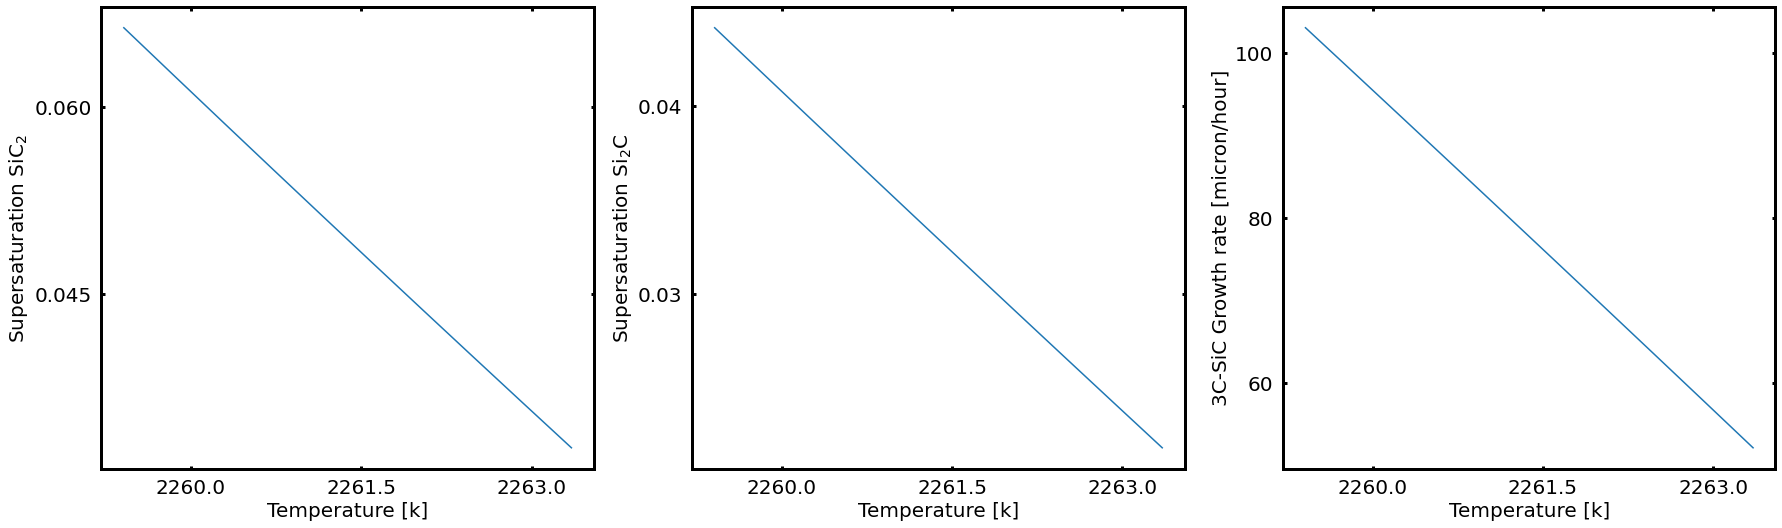

Calibration for vapor pressure: lilov


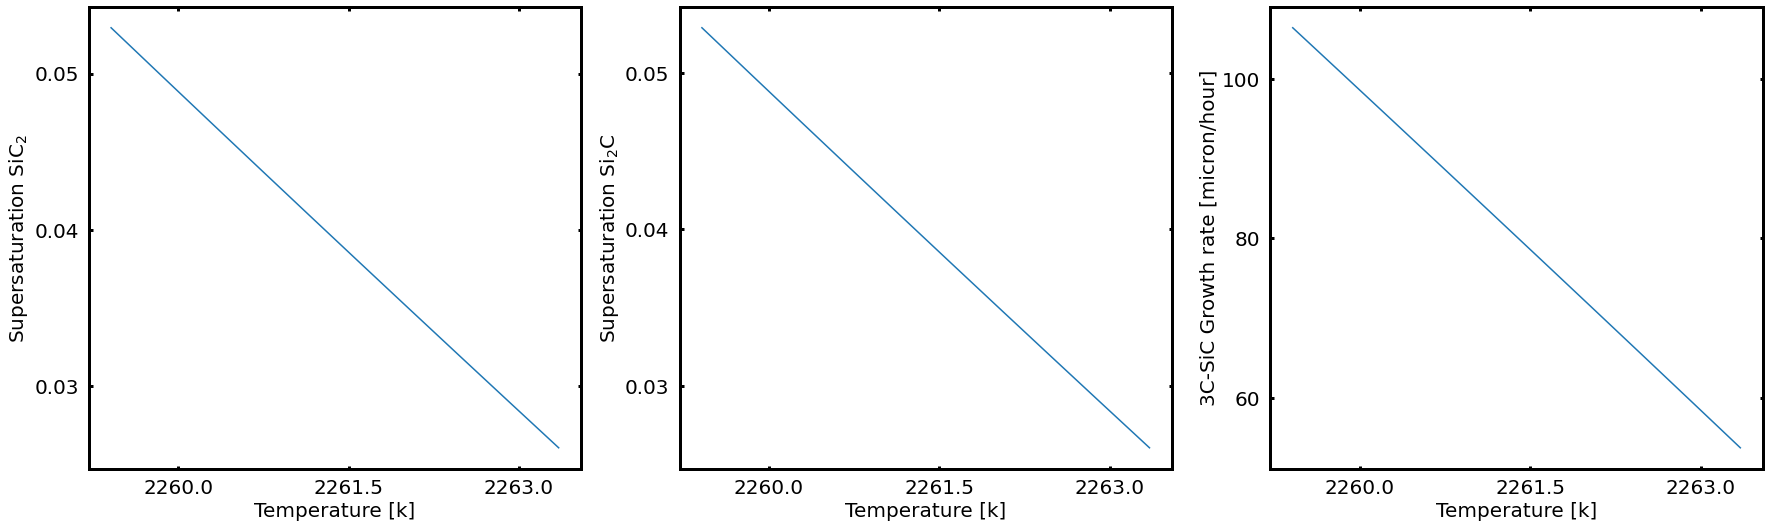


Process ID: 148
The chamber power is: 5.85 kW
Seed-middle temperature: 2313.34 [K]
Seed-edge temperature: 2317.3050000000003 [K]
Source temperature: 2321.27 [K]
Source - Seed-center temperature: 7.929999999999836 [K]
Source - Seed-edge temperature: 3.9649999999996908 [K]

Calibration for vapor pressure: avrov


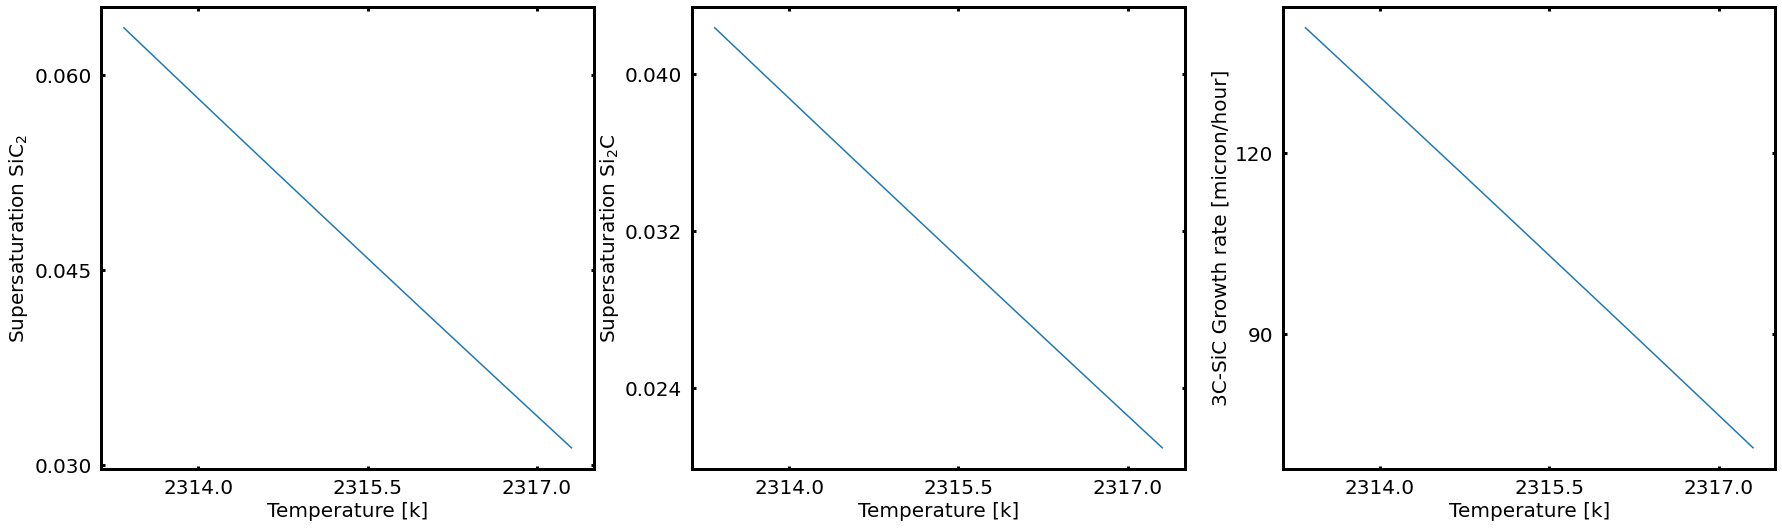

Calibration for vapor pressure: lilov


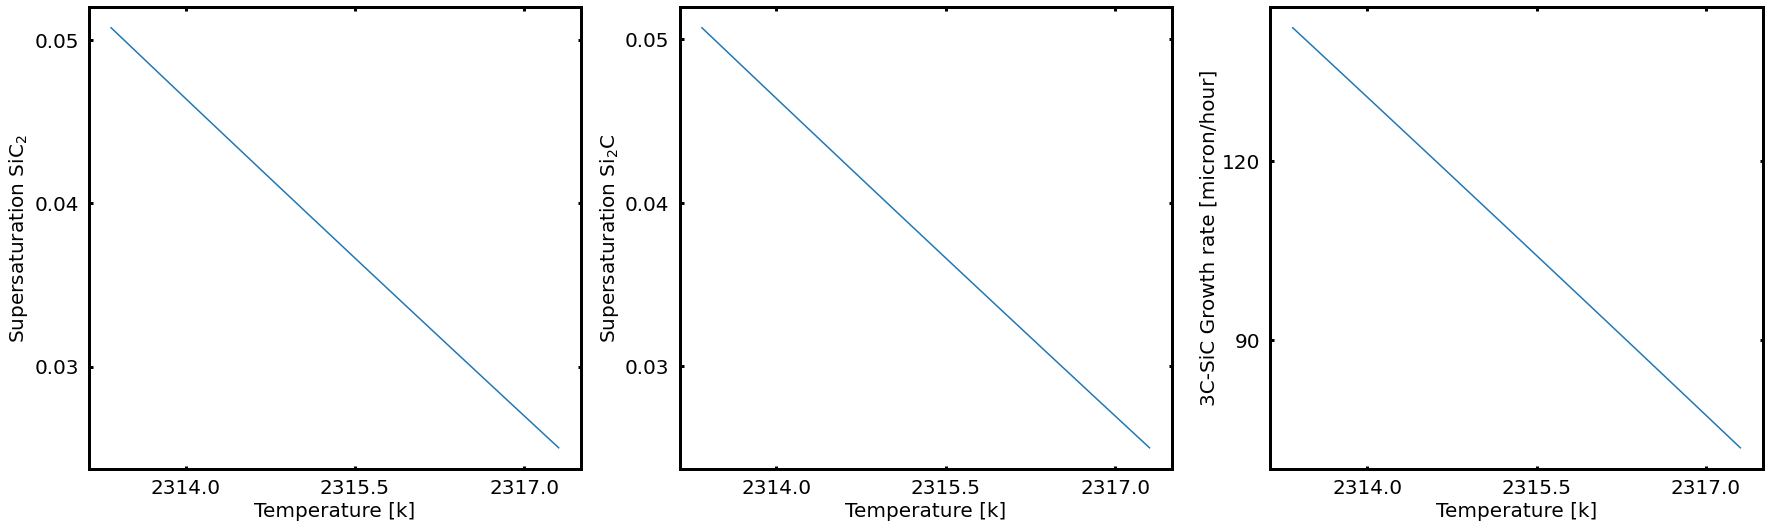


Process ID: 149
The chamber power is: 5.9 kW
Seed-middle temperature: 2319.85 [K]
Seed-edge temperature: 2323.815 [K]
Source temperature: 2327.78 [K]
Source - Seed-center temperature: 7.930000000000291 [K]
Source - Seed-edge temperature: 3.9650000000001455 [K]

Calibration for vapor pressure: avrov


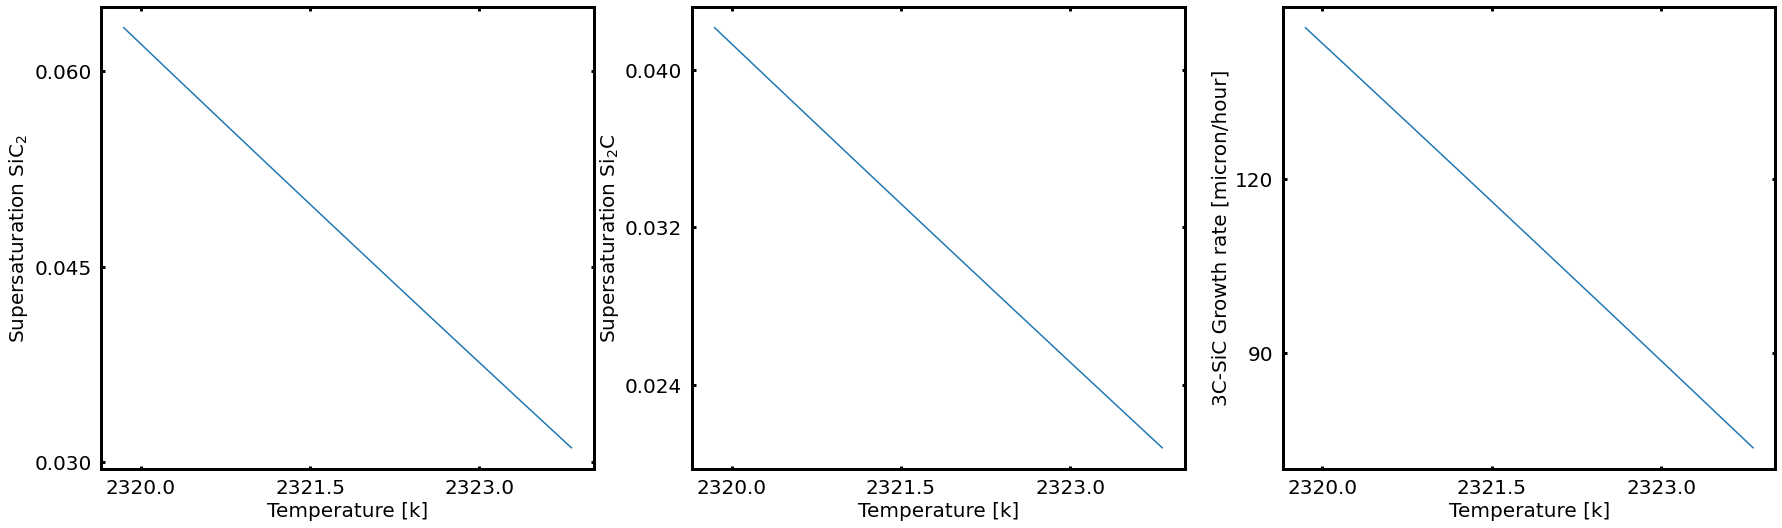

Calibration for vapor pressure: lilov


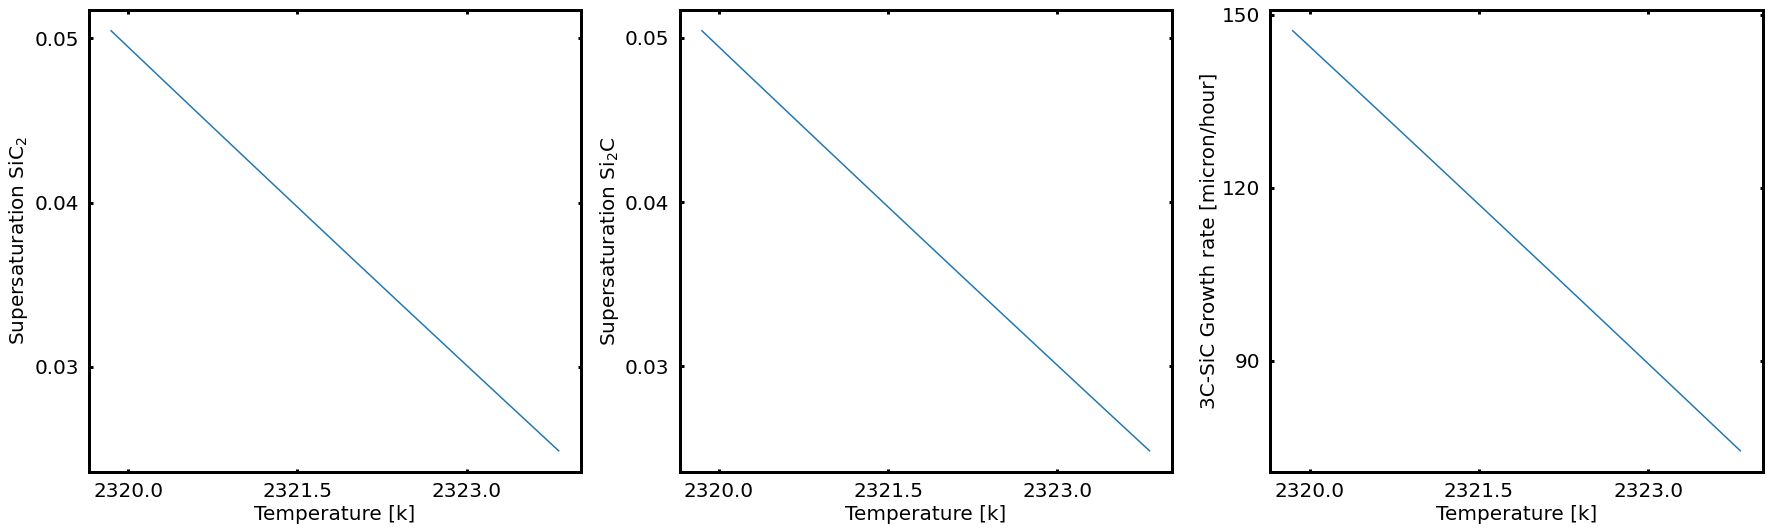


Process ID: 152
The chamber power is: 6.0 kW
Seed-middle temperature: 2332.71 [K]
Seed-edge temperature: 2336.6850000000004 [K]
Source temperature: 2340.6600000000003 [K]
Source - Seed-center temperature: 7.950000000000273 [K]
Source - Seed-edge temperature: 3.974999999999909 [K]

Calibration for vapor pressure: avrov


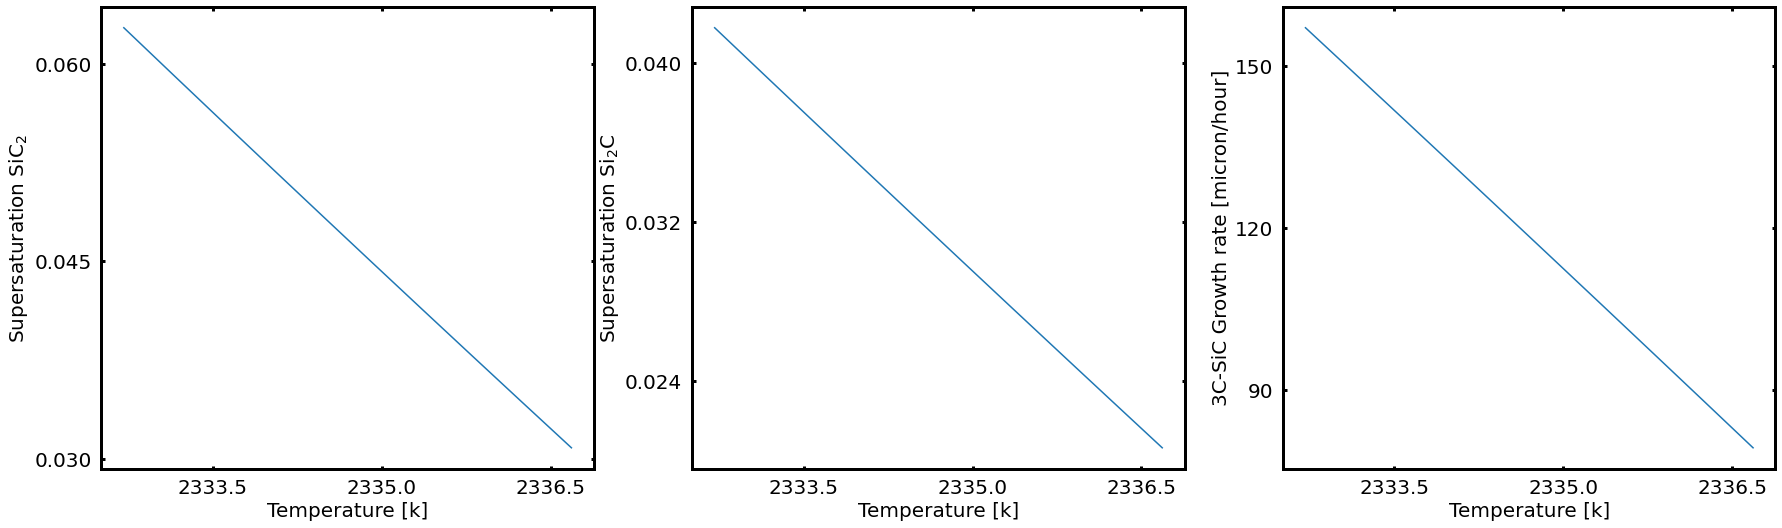

Calibration for vapor pressure: lilov


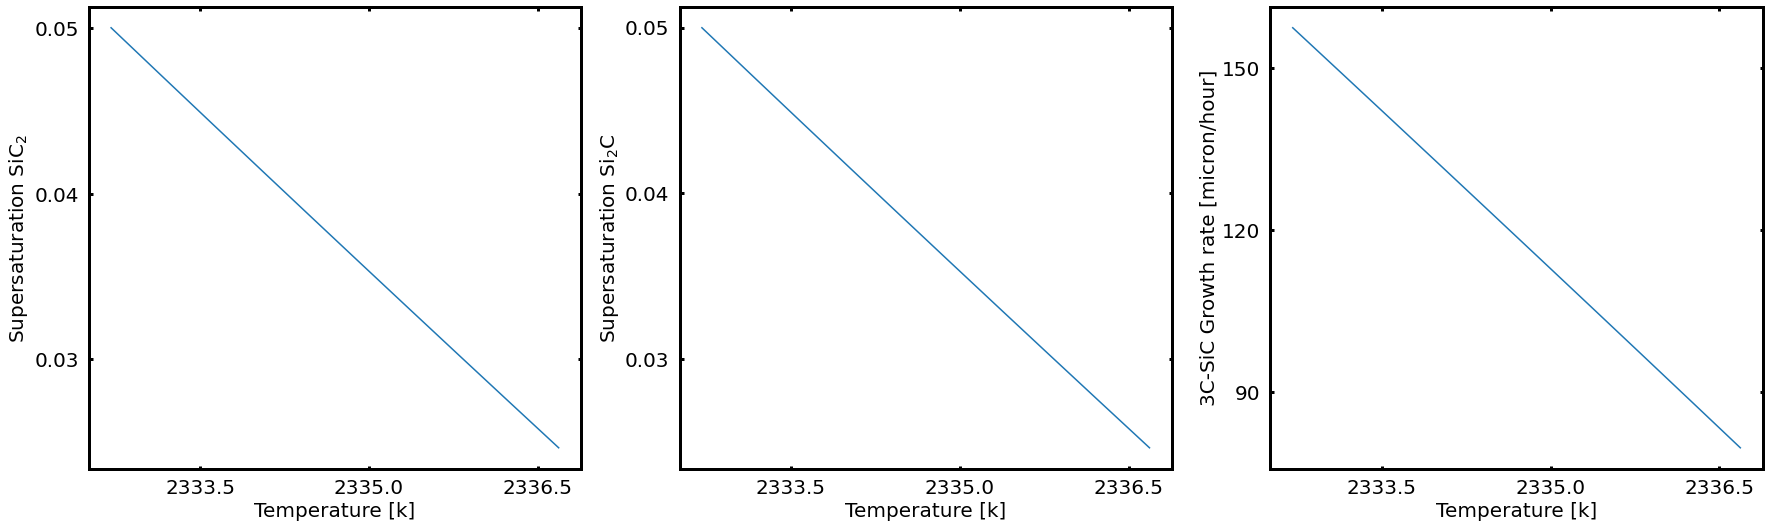


Process ID: 153
The chamber power is: 6.1 kW
Seed-middle temperature: 2345.39 [K]
Seed-edge temperature: 2349.37 [K]
Source temperature: 2353.35 [K]
Source - Seed-center temperature: 7.960000000000036 [K]
Source - Seed-edge temperature: 3.980000000000018 [K]

Calibration for vapor pressure: avrov


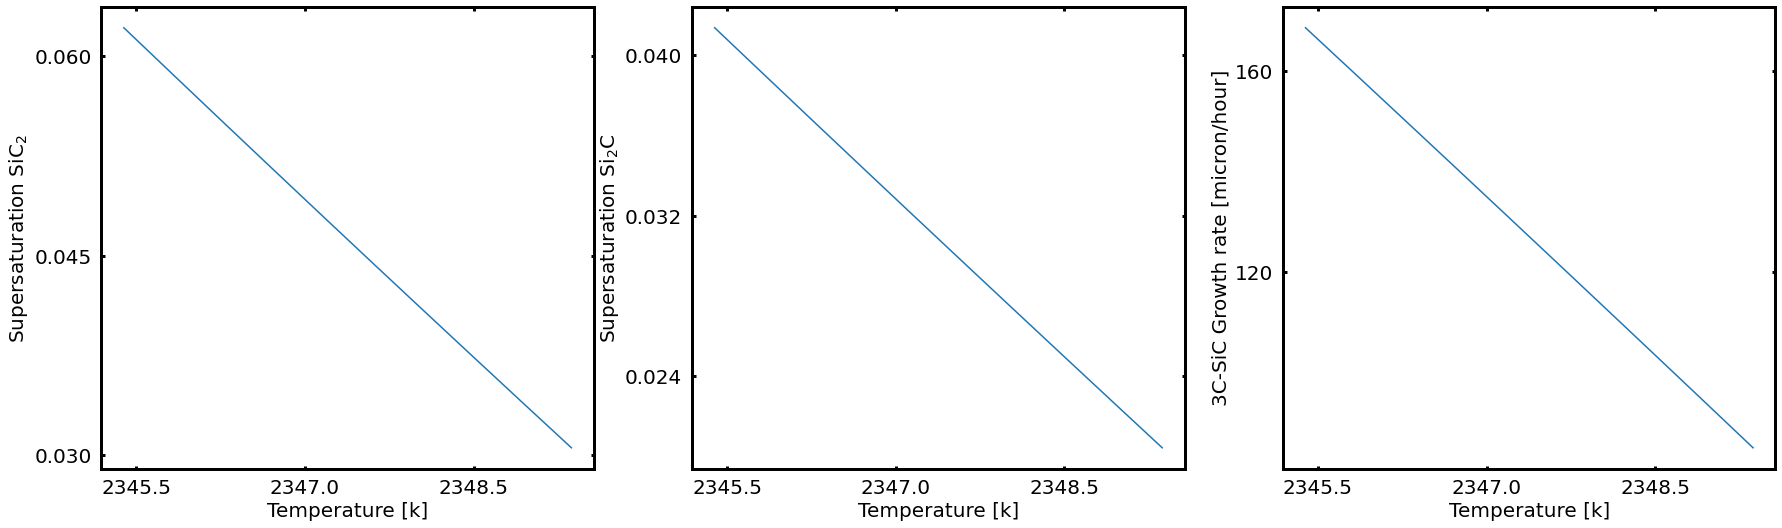

Calibration for vapor pressure: lilov


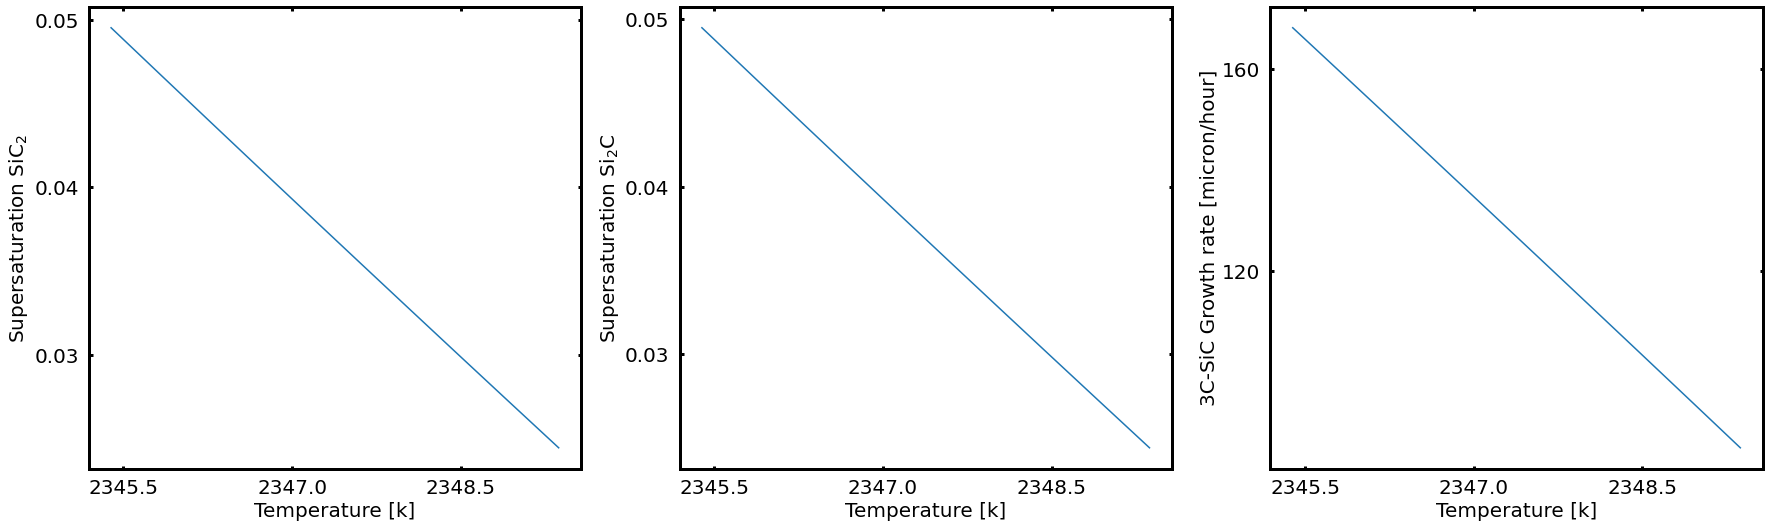

In [9]:
# Rigid shift for all source, seed-middle and seed-edge temperature
delta_T = 0.0

for key in data_samples:
    print('Process ID: {}'.format(key))
    print('The chamber power is: {} kW'.format(data_samples[key]['Power']))
    Tseed_center = data_samples[key]['T_seed_middle'] + T_zero_kelvin + delta_T
    Tsource = (data_samples[key]['T_source_middle'] + data_samples[key]['T_source_edge']) * 0.5 + T_zero_kelvin + delta_T
    # Old glass dataset
    #Tseed_edge = data_samples[key]['T_seed_edge'] + T_zero_kelvin + delta_T
    # New glass data set
    Tseed_edge = Tseed_center + (Tsource - Tseed_center)*0.5 
    print('Seed-middle temperature: {} [K]'.format(Tseed_center))
    print('Seed-edge temperature: {} [K]'.format(Tseed_edge))
    print('Source temperature: {} [K]'.format(Tsource))
    delta_source_seed_center = Tsource - Tseed_center
    print('Source - Seed-center temperature: {} [K]'.format(delta_source_seed_center))
    delta_source_seed_edge = Tsource - Tseed_edge
    print('Source - Seed-edge temperature: {} [K]'.format(delta_source_seed_edge))
    print('')
    data = get_data_avrov_lilov(Tsource,Tseed_center,Tseed_edge)
    for data_name in data_names:
        print('Calibration for vapor pressure: {}'.format(data_name))
        plot_lines(data,data_name)
    print('')
    

## Process window

In [10]:
def z_func(data_name,Tsource_curr,DeltaT_source_seed_center):
    Tsource = Tsource_curr
    Tseed_center = Tsource_curr - DeltaT_source_seed_center
    Tseed_edge = Tsource_curr - DeltaT_source_seed_center * 0.5
    data = get_data_avrov_lilov(Tsource,Tseed_center,Tseed_edge)
    data_to_plot = data[data_name]
    value = data_to_plot[0]['Gr_SiC'] # Growth rate at middle seed position
    return value

In [11]:
def get_two_dimensional_plt(data_name):
    from pylab import pcolor
    Tsource_start = 1900
    Tsource_end = Tsource_start + 200.0 
    Tsource_vect = np.linspace(Tsource_start, Tsource_end, 400)

    Delta_Tsource_Tseed_center_vect = np.linspace(0.0, 50.0, 100)

    Z = np.zeros((len(Delta_Tsource_Tseed_center_vect),len(Tsource_vect),))

    X, Y = np.meshgrid(Tsource_vect, Delta_Tsource_Tseed_center_vect)

    for i in range(len(Tsource_vect)):
        for j in range(len(Delta_Tsource_Tseed_center_vect)):
            Z[j,i] = z_func(data_name,Tsource_vect[i]+ T_zero_kelvin,Delta_Tsource_Tseed_center_vect[j])

    fig = plt.figure(figsize=(20,11))

    #im = plt.imshow(Z, cmap=plt.cm.RdBu, extent=(Tsource_start-T_zero_kelvin, Tsource_end-T_zero_kelvin, Delta_Tsource_Tseed_center_vect[-1], Delta_Tsource_Tseed_center_vect[0]))  
    im = pcolor(X,Y, Z, cmap='RdBu' )
    cset = plt.contour(Z, np.arange(100, 301, 50), linewidths=2,
                       cmap=plt.cm.Set2,
                       extent=(Tsource_start, Tsource_end, Delta_Tsource_Tseed_center_vect[0], Delta_Tsource_Tseed_center_vect[-1]))
    plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=20)
    cbar=plt.colorbar(im)
    cbar.ax.get_yaxis().labelpad = 50
    cbar.set_label('Growth rate at middle seed [micron/hour]', rotation=270)

    print('Experimental growth rates')
    for key in data_samples:
        Tseed_center_exp = data_samples[key]['T_seed_middle']
        Tsource_exp = (data_samples[key]['T_source_middle'] + data_samples[key]['T_source_edge']) * 0.5
        delta_exp = Tsource_exp - Tseed_center_exp 
        plt.scatter(Tsource_exp,delta_exp,color='red')
        if key == '148':
            plt.text(Tsource_exp-9,delta_exp+1,data_samples[key]['Exp-Growth-Rate'],size=20)
        else:
            plt.text(Tsource_exp+1,delta_exp+1,data_samples[key]['Exp-Growth-Rate'],size=20)
        print('Process ID {}: {} [micron/hour]'.format(key,data_samples[key]['Exp-Growth-Rate']))

    plt.tick_params(axis="x", pad=15)
    plt.xlabel('$T_{source}$ [$^{\circ}$C]', size=25)
    plt.ylabel('$T_{source} - T_{seedmiddle}$ [$^{\circ}$C]', size=30)
    if data_name == 'avrov':
        plt.title('3C-SiC epitaxial growth - Avrov calibrartion', size=30, pad=10)
    elif data_name == 'lilov':
        plt.title('3C-SiC epitaxial growth - Lilov calibrartion', size=30, pad=10)

    plt.savefig('figure-2D'+data_name+'.pdf')
    plt.show()
    return

Red dots represent the experimental processes.



/Users/giuseppefisicaro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Experimental growth rates
Process ID 151: 101 [micron/hour]
Process ID 148: 208 [micron/hour]
Process ID 149: 230 [micron/hour]
Process ID 152: 231 [micron/hour]
Process ID 153: 287 [micron/hour]


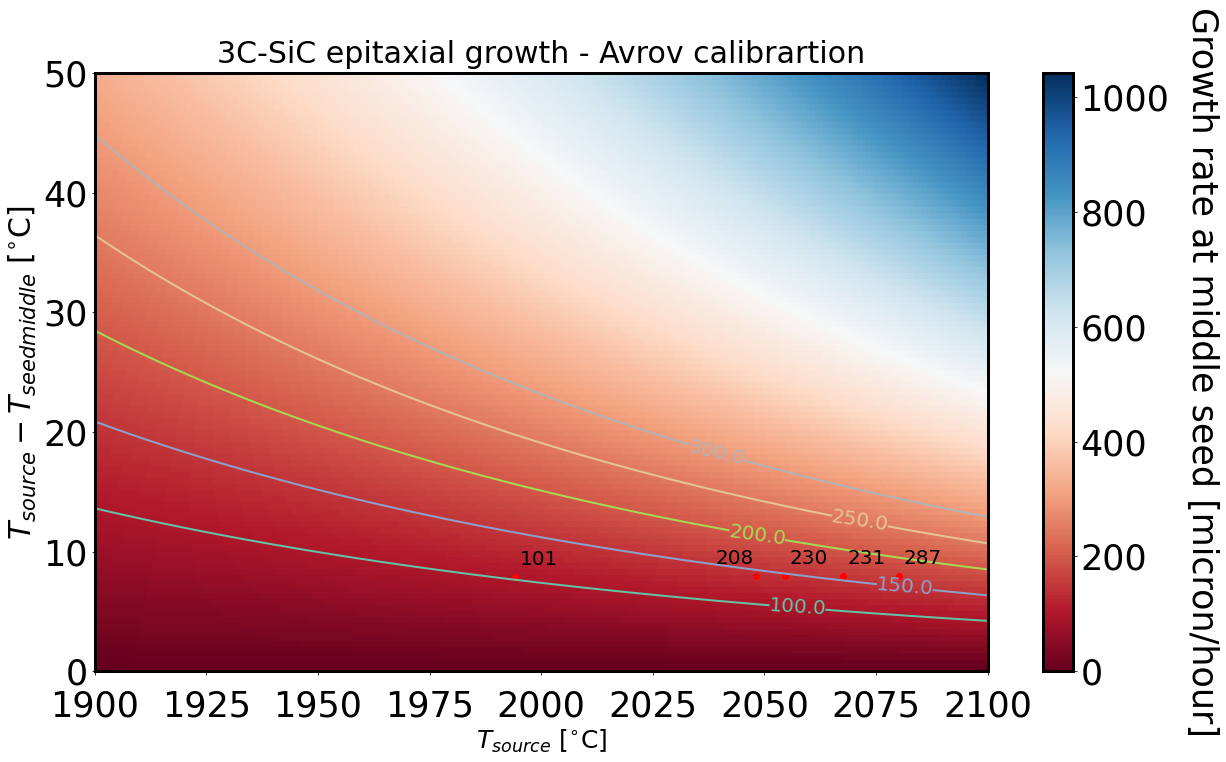

/Users/giuseppefisicaro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Experimental growth rates
Process ID 151: 101 [micron/hour]
Process ID 148: 208 [micron/hour]
Process ID 149: 230 [micron/hour]
Process ID 152: 231 [micron/hour]
Process ID 153: 287 [micron/hour]


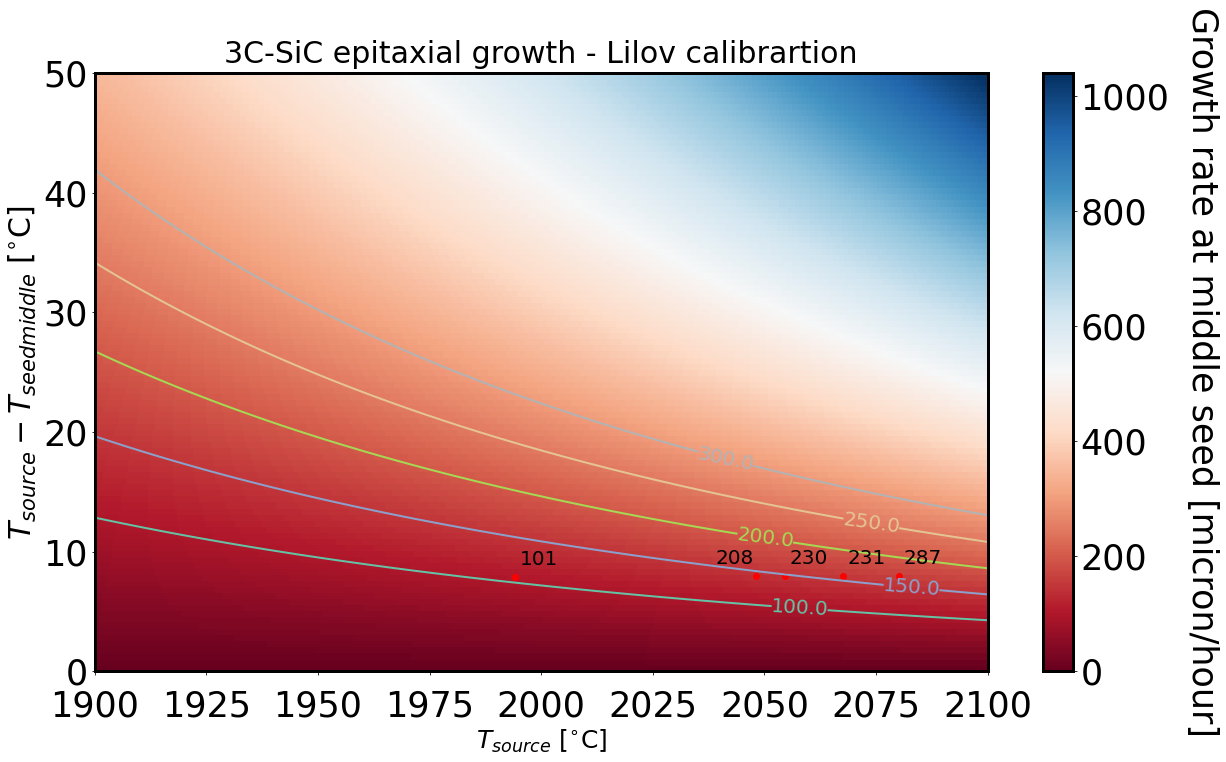

In [12]:
print('Red dots represent the experimental processes.')
print('')
for data_name in data_names:
    get_two_dimensional_plt(data_name)

## Calibration and input file generation

To set up the input file `start.dat` of mulskips, you have to update the `data_samples` dictionary for the current experimental processes, choose your particular process with the setting of `key` variable below and choose the particular calibration for vapor presure of 3C-SiC with the variable `data_name`.
You can definve `Tseed_center` or with the `DeltaT_source_seed_center` or directily from the `data_samples` dictionary.

Alternatively you can set up directily `Tsource` (for the evaporation frequencies) and `Tseed_center` (for the deposition frequencies) and `data_name`, without using the experimental temperatures from the `data_samples` dictionary.

In [13]:
# FUNDAMENTAL SETTING !!!

# This is the only cell to be set for the input file generation.
key = '151' # experimental dataset

Tsource = (data_samples[key]['T_source_middle'] + data_samples[key]['T_source_edge']) * 0.5 + T_zero_kelvin # [K]

#DeltaT_source_seed_center = 10 # [K]
#Tseed_center = Tsource - DeltaT_source_seed_center
Tseed_center = data_samples[key]['T_seed_middle'] + T_zero_kelvin # [K]

# Set the vapor pressure calibration
data_name = 'avrov'

# Probability for the stacking fault generation
PtransZig = 1.0

# Variable to set for the initial system:
# S Sphere
# C Parellelepipid
# F Flat (100) surface
# A Antiphase boundary APB
# I inverted pyramid
# D inverted pyramid of C
# Z inverted pyramid of Si
# J inverted pyramid with APB
Simulation = "F"

# Size of the initial system
Seed_box = [120, 120, 120] # Len1 Len2 Len3

filename = 'start-3C-SiC-PVD.dat' # name of the output file where the mulskips input keys are stored.
                                  # This as to be renamed as start.dat to run mulskips. 

### Ab-initio energetics

Following we report the ab-initio DFT energetics for the binding energies [eV] of a single silicon or carbon atom with a single/double/triple bond coordination to a 3C-SiC surface. Details are reported in the suplementary material of the paper Fisicaro et al. Appl. Phys. Rev. 7, 021402 (2020).

In [14]:
ESi=np.zeros((4, 4)) # Si energetics of evaporation in eV
EC=np.zeros((4, 4)) # C energetics of evaporation in eV

f=4 # factor for the energetics interpolation

# Coordination 1 of Si from 111 C-terminated 4x1x2 bigdft surface
ESi[0,1]= -6.83 # -4.39 BigDFT # -6.83 # QE 
# Coordination 2 of Si from 100 Si-terminated 3x1x3 dimer surface
ESi[0,2]=-7.04
# Coordination 3 of Si from 111 Si-terminated 4x1x2 surface
ESi[0,3]=-7.77
# Coordination 1 of Si adatom optimized on 111 Si-terminated 4x1x2 surface
ESi[1,0]=-6.72
ESi[1,1]=(f*ESi[1,0]+ESi[0,2])/(f+1) # -6.8 # ESi[1,0] < ESi[1,1] < ESi[0,2]
ESi[1,2]=(f*ESi[0,2]+ESi[0,3])/(f+1) # -6.8 # ESi[0,2] < ESi[1,2] < ESi[0,3]
ESi[2,1]=(f*ESi[1,1]+ESi[0,3])/(f+1) # -6.8 # ESi[1,1] < ESi[2,1] < ESi[0,3]
ESi[2,0]=(f*ESi[1,0]+ESi[2,1])/(f+1) # -6.8 # ESi[1,0] < ESi[2,0] < ESi[2,1]
ESi[3,0]=(f*ESi[2,0]+ESi[2,1])/(f+1) # -6.8 # ESi[2,0] < ESi[3,0] < ESi[2,1]

# Coordination 1 of C from 111 Si-terminated 4x1x2 surface
EC[1,0]=-9.10
# Coordination 2 of C from 100 C-terminated 3x1x3 dimer surface
EC[2,0]=-11.43
# Coordination 3 of C from 111 C-terminated 4x1x2 bigdft surface
EC[3,0]=-11.80
# Coordination 1 of C adatom optimized on 111 C-terminated 4x1x2 bigdft surface
EC[0,1]=-7.76
EC[1,1]= (f*EC[1,0]+EC[2,0])/(f+1) #  -9.8 # EC[1,0] < EC[1,1] < EC[2,0]
EC[1,2]= (f*EC[1,1]+EC[3,0])/(f+1) # -10.0 # EC[1,1] < EC[1,2] < EC[3,0]
EC[0,2]= (f*EC[0,1]+EC[1,2])/(f+1) # -8.1 # EC[0,1] < EC[0,2] < EC[1,2] 
EC[2,1]= (f*EC[2,0]+EC[3,0])/(f+1) # -11.6 # EC[2,0] < EC[2,1] < EC[3,0]
EC[0,3]= (f*EC[0,2]+EC[1,2])/(f+1) # -9.1 # EC[0,2] < EC[0,3] < EC[1,2]

### Evaporation Frequencies

In [15]:
Temperature = Tseed_center # Set temperature only here for the whole evaporation frequencies section

In [16]:
Bolt_Si=np.zeros((4, 4)) # Probabilities of Si
Bolt_C=np.zeros((4, 4)) # Probabilities of C

Bolt_Si=np.exp(ESi/(kb_ev * Temperature))
Bolt_C =np.exp(EC/(kb_ev * Temperature))

In [17]:
loc_fluxes = get_fluxes(data_name,Temperature) # mol/s/m^2
Si_flux_ev = loc_fluxes['Si'] + 2.0*loc_fluxes['Si2C'] + loc_fluxes['SiC2']
C_flux_ev = loc_fluxes['Si2C'] + 2.0*loc_fluxes['SiC2']

In [18]:
freq_0 = M_SiC / rho_surf_SiC # m^2 / mol
PtransE_Si = freq_0*Si_flux_ev*Bolt_Si/Bolt_Si[0,2] # at/s
PtransE_C = freq_0*C_flux_ev*Bolt_C/Bolt_C[2,0] # at/s

In [19]:
print(freq_0)

28639.301782948864


In [20]:
print(PtransE_Si)

[[2.38890989e+19 1.39119647e+04 4.73116621e+03 1.11339729e+02]
 [2.44766207e+04 1.76195498e+04 2.23513931e+03 2.38890989e+19]
 [1.87165734e+04 6.39920287e+03 2.38890989e+19 2.38890989e+19]
 [1.51010189e+04 2.38890989e+19 2.38890989e+19 2.38890989e+19]]


In [21]:
print(PtransE_C)

[[3.98027384e+28 1.95285083e+11 1.93046642e+10 3.03149457e+09]
 [2.00309570e+08 1.82917323e+07 1.84346532e+06 3.98027384e+28]
 [1.27194224e+03 8.69771179e+02 3.98027384e+28 3.98027384e+28]
 [1.90175910e+02 3.98027384e+28 3.98027384e+28 3.98027384e+28]]


### Deposition Frequencies

In [22]:
Temperature = Tsource # Set temperature only here for the whole deposition frequencies section

In [23]:
Bolt_Si=np.zeros((4, 4)) # Probabilities of Si
Bolt_C=np.zeros((4, 4)) # Probabilities of C

Bolt_Si=np.exp(ESi/(kb_ev * Temperature))
Bolt_C =np.exp(EC/(kb_ev * Temperature))

In [24]:
loc_fluxes = get_fluxes(data_name,Temperature) # mol/s/m^2
Si_flux_ev = loc_fluxes['Si'] + 2.0*loc_fluxes['Si2C'] + loc_fluxes['SiC2']
C_flux_ev = loc_fluxes['Si2C'] + 2.0*loc_fluxes['SiC2']

In [25]:
freq_0 = M_SiC / rho_surf_SiC # m^2 / mol
PtransD_Si = freq_0*Si_flux_ev*Bolt_Si/Bolt_Si[0,2] # at/s
PtransD_C = freq_0*C_flux_ev*Bolt_C/Bolt_C[2,0] # at/s

In [26]:
PtransD=np.zeros(6)

In [27]:
fact_D = [1.10546, 200.0, 0.276365, 2.5, 44.2184, 400.0]
#fact_D = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
preD = 0.38

In [28]:
PtransD[0]=preD*fact_D[0]*PtransD_Si[0,2] # Si coord 1, old 1
PtransD[1]=preD*fact_D[1]*PtransD_C[2,0] # C  coord 1, old 1
PtransD[2]=preD*fact_D[2]*PtransD_Si[0,2] # Si coord 2, old 2
PtransD[3]=preD*fact_D[3]*PtransD_C[2,0]  # C  coord 2, old 2
PtransD[4]=preD*fact_D[4]*PtransD_Si[0,2] # Si coord 3, old 20
PtransD[5]=preD*fact_D[5]*PtransD_C[2,0] # C  coord 3, old 20

In [29]:
print(PtransD)

[  2058.71938832 101656.52094855    514.67984708   1270.70651186
  82348.77553287 203313.0418971 ]


### Generation of the kinetic Monte Carlo input file

In [30]:
def print_file_input(filename,PtransE_Si,PtransE_C,PtransD,PtransZig,Simulation,Sedd_box):
    file = open(filename,"w") 

    file.write(str(PtransE_Si[0,1])+" ! PtransE_Si[0,1]" + "\n") 
    file.write(str(PtransE_Si[1,0])+" ! PtransE_Si[1,0]" + "\n")
    file.write(str(PtransE_Si[1,1])+" ! PtransE_Si[1,1]" + "\n") 
    file.write(str(PtransE_Si[0,2])+" ! PtransE_Si[0,2]" + "\n") 
    file.write(str(PtransE_Si[2,0])+" ! PtransE_Si[2,0]" + "\n") 
    file.write(str(PtransE_Si[2,1])+" ! PtransE_Si[2,1]" + "\n") 
    file.write(str(PtransE_Si[1,2])+" ! PtransE_Si[1,2]" + "\n") 
    file.write(str(PtransE_Si[0,3])+" ! PtransE_Si[0,3]" + "\n") 
    file.write(str(PtransE_Si[3,0])+" ! PtransE_Si[3,0]" + "\n") 

    file.write(str(PtransE_C[0,1])+" ! PtransE_C[0,1]" + "\n") 
    file.write(str(PtransE_C[1,0])+" ! PtransE_C[1,0]" + "\n")
    file.write(str(PtransE_C[1,1])+" ! PtransE_C[1,1]" + "\n") 
    file.write(str(PtransE_C[0,2])+" ! PtransE_C[0,2]" + "\n") 
    file.write(str(PtransE_C[2,0])+" ! PtransE_C[2,0]" + "\n") 
    file.write(str(PtransE_C[2,1])+" ! PtransE_C[2,1]" + "\n") 
    file.write(str(PtransE_C[1,2])+" ! PtransE_C[1,2]" + "\n") 
    file.write(str(PtransE_C[0,3])+" ! PtransE_C[0,3]" + "\n") 
    file.write(str(PtransE_C[3,0])+" ! PtransE_C[3,0]" + "\n") 

    file.write(str(PtransD[0])+" ! PtransD[1]" + "\n") 
    file.write(str(PtransD[1])+" ! PtransD[2]" + "\n") 
    file.write(str(PtransD[2])+" ! PtransD[3]" + "\n") 
    file.write(str(PtransD[3])+" ! PtransD[4]" + "\n") 
    file.write(str(PtransD[4])+" ! PtransD[5]" + "\n") 
    file.write(str(PtransD[5])+" ! PtransD[6]" + "\n") 

    file.write(str(PtransZig)+" ! PtransZig" + "\n")

    file.write(Simulation+" ! Initstat: S Sphere, C Parellelepipid, F Flat (100) surface, A APB, I inverted pyramid, D inverted pyramid of C, Z inverted pyramid of Si, J inverted pyramid with APB " +  "\n")

    Sys_size=str(Seed_box[0])+' '+str(Seed_box[1])+' '+str(Seed_box[2])
    file.write(Sys_size+" ! Len1 Len2 Len3" + "\n")
    
#    file.write("100000  ! OutMolMol -> output frequency" + "\n")
#    file.write("100000000 ! IterMax -> Max number of iterations" + "\n")
    
    file.write("1000000  ! OutMolMol -> output frequency" + "\n")
    file.write("100000000 ! IterMax -> Max number of iterations" + "\n")

    
    file.write("10000   ! exit_zeta strategy after lenz=500 " + "\n")
    file.write("R   ! R = production run; T = run test with a fixed sequence of random numbers " + "\n")
    
    file.close() 
    return "printing done"

## MulSKIPS run

To run mulskips, the user is supposed to set only the variables inside the cell below.

In [31]:
# Full path of the compiled mulskips executable:
mulskipsexecutable = '/Users/giuseppefisicaro/Documents/mulskips-notebook-vapor/mulskips-build/mulskips.e | tee log.txt;'

run_name = 'P-'+key

In [32]:
# detect the current working directory and print it
path = os.getcwd()
print ("The current working directory is %s" % path)

The current working directory is /Users/giuseppefisicaro/Documents/mulskips-notebook-vapor/wellmann-project


In [33]:
# create the directory run_name where to run the mulskips code
rundir=path+'/'+run_name

In [34]:
try:
    # remove the testdir directory if it already exist
    shutil.rmtree(rundir)
except OSError as e:
    print("Error: %s : %s" % (rundir, e.strerror))

In [35]:
try:
    os.mkdir(rundir)
except OSError:
    print ("Creation of the directory %s failed" % rundir)
else:
    print ("Successfully created the directory %s " % rundir)

Successfully created the directory /Users/giuseppefisicaro/Documents/mulskips-notebook-vapor/wellmann-project/P-151 


In [36]:
try:
    # Change from current working Directory to rundir    
    os.chdir(rundir)
    print('Directory changed to: {}'.format(rundir))
except OSError:
    print("Can't change the Current Working Directory")

Directory changed to: /Users/giuseppefisicaro/Documents/mulskips-notebook-vapor/wellmann-project/P-151


In [37]:
print_file_input('start.dat',PtransE_Si,PtransE_C,PtransD,PtransZig,Simulation,Seed_box)

'printing done'

In [38]:
# execute the mulskips.e program with the input file start.dat
make_process = subprocess.Popen(mulskipsexecutable, shell=True, stdout=subprocess.PIPE)
while True:
    line = make_process.stdout.readline()
    if not line:break
    print(line) #output to console in time
    sys.stdout.flush()

b' IDUM    -9117116\n'
b' numParticelle=      500000 Levels =          20 , SizeTree =     1048575\n'
b'      124800           0        6400\n'
b' I00000000\n'
b' NumAtWrong:            0\n'
b'           0\n'
b' I00000001\n'
b' NumAtWrong:          117\n'
b'           0\n'
b' Iter     1000000   2.6322450187327780E-003         126         156         126\n'
b' NatNvoidNad      122839           1        9279\n'
b' I00000002\n'
b' NumAtWrong:          101\n'
b'           0\n'
b' Iter     2000000   4.8008882264818312E-003          30         378         120\n'
b' NatNvoidNad      123341           0        9397\n'
b' I00000003\n'
b' NumAtWrong:          132\n'
b'           0\n'
b' Iter     3000000   6.9165456782601890E-003         147         135         123\n'
b' NatNvoidNad      123979           1        9432\n'
b' I00000004\n'
b' NumAtWrong:           82\n'
b'           0\n'
b' Iter     4000000   8.9724627041443163E-003         318         456         126\n'
b' NatNvoidNad      124722   

b'           0\n'
b' Iter    40000000   8.2831364170982011E-002         351          81         141\n'
b' NatNvoidNad      149612           0        9509\n'
b' I00000041\n'
b' NumAtWrong:          130\n'
b'           0\n'
b' Iter    41000000   8.4845016014119201E-002         108         420         144\n'
b' NatNvoidNad      150526           2        9505\n'
b' I00000042\n'
b' NumAtWrong:          122\n'
b'           0\n'
b' Iter    42000000   8.6873216030178321E-002          12          54         150\n'
b' NatNvoidNad      151197           1        9433\n'
b' I00000043\n'
b' NumAtWrong:           96\n'
b'           0\n'
b' Iter    43000000   8.8893278510757165E-002         219         411         147\n'
b' NatNvoidNad      151742           1        9560\n'
b' I00000044\n'
b' NumAtWrong:           94\n'
b'           0\n'
b' Iter    44000000   9.0933703100058508E-002         273         303         141\n'
b' NatNvoidNad      152289           2        9397\n'
b' I00000045\n'
b' NumAtWro

b' NatNvoidNad      175630           1        9400\n'
b' I00000081\n'
b' NumAtWrong:          113\n'
b'           0\n'
b' Iter    81000000  0.16711665687950991               18         186         180\n'
b' NatNvoidNad      176269           0        9441\n'
b' I00000082\n'
b' NumAtWrong:          152\n'
b'           0\n'
b' Iter    82000000  0.16920304270474623              330           6         168\n'
b' NatNvoidNad      177118           1        9467\n'
b' I00000083\n'
b' NumAtWrong:          109\n'
b'           0\n'
b' Iter    83000000  0.17127352222023826              156         162         174\n'
b' NatNvoidNad      177898           0        9471\n'
b' I00000084\n'
b' NumAtWrong:          112\n'
b'           0\n'
b' Iter    84000000  0.17332504867670034              285         117         171\n'
b' NatNvoidNad      178429           0        9506\n'
b' I00000085\n'
b' NumAtWrong:          106\n'
b'           0\n'
b' Iter    85000000  0.17536771303936419              390        

In [39]:
!rm *.src
!mkdir xyz
!mkdir d_xyz
!mkdir v_xyz
!mkdir w_xyz
!mv I*_d.xyz d_xyz/
!mv I*_v.xyz v_xyz/
!mv I*_w.xyz w_xyz/
!mv I*.xyz xyz/

In [40]:
!ls

DefAtEnergy.dat d_xyz           log.txt         start.dat       w_xyz
Run_time.dat    fort.30         movie.mos       v_xyz           xyz


In [41]:
#path = '/Users/giuseppefisicaro/Documents/mulskips-notebook-vapor/wellmann-project/'
try:
    # Change from current working Directory to path    
    os.chdir(path)
    print('Directory changed to: {}'.format(path))
except OSError:
    print("Can't change the Current Working Directory") 
print('')

Directory changed to: /Users/giuseppefisicaro/Documents/mulskips-notebook-vapor/wellmann-project



## Analysis of epitaxial-growth substrate quality and defects

Then we need to collect all the output \*.xyz files from the mulskips run.

In [42]:
# Collect all *.xyz files within the run_dir directory related to the undercoordinated atoms,
# that are the files I00000000.xyz, I00000001.xyz etc ...
files_list = os.listdir(rundir+'/xyz')
files_list.sort()

# Un comment these lines if you want to list all files in the directory 'run_dir'
#print('All files are:')
#print(files_list)
#print('')

undercoordinated_atoms = []
for file in files_list:
    if file[-3:] == 'xyz':
        if file[-5].isnumeric():
            undercoordinated_atoms.append(file)

#for ele in undercoordinated_atoms:
#    print(ele)

In [43]:
def get_box_sides(filename):
    with open (filename) as f:
        content = f.read().splitlines()
        line=content[1]
        splitline = line.split()
        acell_x=float(splitline[1])
        acell_y=float(splitline[2])
        acell_z=float(splitline[3])
    return [acell_x,acell_y,acell_z]

In [44]:
file=undercoordinated_atoms[0]

In [45]:
xyz_file = open(rundir+'/xyz/'+file).read()
xyzview = py3Dmol.view(width=400,height=800)
xyzview.addModel(xyz_file,'xyz')
xyzview.setStyle({'sphere':{'colorscheme':'Jmol','scale':.5},'stick':{'colorscheme':'Jmol'}})
#viewer.zoomTo();
#viewer.rotate(45, {'x':1,'y':1,'z':1});
#xyzview.addUnitCell()
#xyzview.setBackgroundColor('0xeeeeee')
xyzview.rotate(-90, {'x':0.9,'y':-0.01,'z':-0.01})
#xyzview.addBox({'center':{'x':0,'y':0,'z':0},'dimensions': {'w':300,'h':400,'d':200},'color':'magenta'})
acell=get_box_sides(rundir+'/xyz/'+file)
print(acell)
xyzview.addLine({'start':{'x':0,'y':0,'z':0},'end':{'x':0,'y':0,'z':acell[2]}})
xyzview.addLine({'start':{'x':0,'y':0,'z':0},'end':{'x':0,'y':acell[1],'z':0}})
xyzview.addLine({'start':{'x':0,'y':0,'z':0},'end':{'x':acell[0],'y':0,'z':0}})
xyzview.addLine({'start':{'x':0,'y':acell[1],'z':acell[2]},'end':{'x':acell[0],'y':acell[1],'z':acell[2]}})
xyzview.addLine({'start':{'x':acell[0],'y':0,'z':acell[2]},'end':{'x':acell[0],'y':acell[1],'z':acell[2]}})
xyzview.addLine({'start':{'x':acell[0],'y':acell[1],'z':0},'end':{'x':acell[0],'y':acell[1],'z':acell[2]}})
xyzview.addLine({'start':{'x':0,'y':acell[1],'z':0},'end':{'x':acell[0],'y':acell[1],'z':0}})
xyzview.addLine({'start':{'x':acell[0],'y':0,'z':0},'end':{'x':acell[0],'y':acell[1],'z':0}})
xyzview.addLine({'start':{'x':0,'y':0,'z':acell[2]},'end':{'x':0,'y':acell[1],'z':acell[2]}})
xyzview.addLine({'start':{'x':0,'y':0,'z':acell[2]},'end':{'x':acell[0],'y':0,'z':acell[2]}})
xyzview.addLine({'start':{'x':0,'y':acell[1],'z':0},'end':{'x':0,'y':acell[1],'z':acell[2]}})
xyzview.addLine({'start':{'x':acell[0],'y':0,'z':0},'end':{'x':acell[0],'y':0,'z':acell[2]}})

xyzview.zoomTo()
xyzview.show()

[185.20001, 185.20001, 370.40002]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [46]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets

In [47]:
def MolTo3DView(file, size=(400, 800), style="sphere", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        xyz_file: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing xyz_file
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    viewer = py3Dmol.view(width=size[0], height=size[1])
    xyz_file = open(file).read()
    viewer.addModel(xyz_file,'xyz')
    if style=='sphere':
        viewer.setStyle({'sphere':{'colorscheme':'Jmol','scale':.5},'stick':{'colorscheme':'Jmol'}})
    else:
        viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.rotate(-90, {'x':1,'y':0,'z':0})
    acell=get_box_sides(file)
    viewer.addLine({'start':{'x':0,'y':0,'z':0},'end':{'x':0,'y':0,'z':acell[2]}})
    viewer.addLine({'start':{'x':0,'y':0,'z':0},'end':{'x':0,'y':acell[1],'z':0}})
    viewer.addLine({'start':{'x':0,'y':0,'z':0},'end':{'x':acell[0],'y':0,'z':0}})
    viewer.addLine({'start':{'x':0,'y':acell[1],'z':acell[2]},'end':{'x':acell[0],'y':acell[1],'z':acell[2]}})
    viewer.addLine({'start':{'x':acell[0],'y':0,'z':acell[2]},'end':{'x':acell[0],'y':acell[1],'z':acell[2]}})
    viewer.addLine({'start':{'x':acell[0],'y':acell[1],'z':0},'end':{'x':acell[0],'y':acell[1],'z':acell[2]}})
    viewer.addLine({'start':{'x':0,'y':acell[1],'z':0},'end':{'x':acell[0],'y':acell[1],'z':0}})
    viewer.addLine({'start':{'x':acell[0],'y':0,'z':0},'end':{'x':acell[0],'y':acell[1],'z':0}})
    viewer.addLine({'start':{'x':0,'y':0,'z':acell[2]},'end':{'x':0,'y':acell[1],'z':acell[2]}})
    viewer.addLine({'start':{'x':0,'y':0,'z':acell[2]},'end':{'x':acell[0],'y':0,'z':acell[2]}})
    viewer.addLine({'start':{'x':0,'y':acell[1],'z':0},'end':{'x':0,'y':acell[1],'z':acell[2]}})
    viewer.addLine({'start':{'x':acell[0],'y':0,'z':0},'end':{'x':acell[0],'y':0,'z':acell[2]}})
    viewer.zoomTo()
    return viewer

In [49]:
def style_selector(idx, s):
    conf = rundir+'/xyz/'+undercoordinated_atoms[idx]
    return MolTo3DView(conf, style=s).show()

interact(style_selector, 
         idx=ipywidgets.IntSlider(min=0,max=len(undercoordinated_atoms)-1, step=1),
         s=ipywidgets.Dropdown(
            options=['line', 'stick', 'sphere'],
            value='sphere',
            description='Style:'))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<function __main__.style_selector(idx, s)>

## Growth rate extraction

The following notebook allows to extract the growth rate from a Super lattice Kinetic Monte Carlo simulation with the mulskips code. It is supposed that you run mulskips for a flat (001) surface, that is "F" letter as input geometry in the file `start.dat` (see the tutorial to run the epitaxial growth of a surface with mulskips).

Firstly, let set the folder where you ran mulskips.
The script will extract the growth rate from the output \*.xyz files.

To calculate the growth rate we have to extract the surface height z$^{\text{surf}}_{\text{ave}}$ at different KMC steps and the running time $t$. Then the growth rate $\eta$ is

$$ \eta = \frac{\text{d} \text{z}^{\text{surf}}_{\text{ave}}}{\text{d}t}  $$

Let start with the determination of the surface height z$^{\text{surf}}_{\text{ave}}$ from a generic output file of the undercoordinated atoms.
To do that we divide the orthorhombic simulation box [x$_l$, y$_l$, z$_l$] in slices along the z-direction.
The size of each z-slice in angstroem is defined by the variable `bin_size`.
Essentially we are storing the z coordinates of all atoms in a histogram with bins of size `bin_size`.

In [50]:
bin_size = 5.0 # [Angstroem] size of the bins in the z direction to store all z-values in an histogram, 5 Angstroem should be ok

Then we check the slice along z which contains the largest number of atoms.
This z-slice corresponds in a first approximation to the region where the growing surface lies.
We calculate the average z coordinate z$_{\text{ave}}^{\text{largest-bin}}$ for atoms belonging to such z-slice.
Then we calculate z$^{\text{surf}}_{\text{ave}}$ as the average of the z-coordinate of all atoms falling in the range
$|z-z_{\text{ave}}^{\text{largest-bin}}| < \text{surface_roughness}$. To set the `surface_roughness` parameter it is recommended to have a look to the \*.xyz files by means of a visualization software to evaluate the extension/quality of the surface roughness. 

In [51]:
surface_roughness = 10.0 # [Angstroem] surface roughness in the z direction where average the surface height.

All the above operation to get z$^{\text{surf}}_{\text{ave}}$ for a given KMC xyz file are coded in the `get_surface_height` function.

In [52]:
# Main function of the notebook to get the surface height from a rough surface.
import numpy as np
def get_surface_height(filename,bin_size=5.0,surface_roughness=20.0):
    # bin_size [Angstroem] represents the size of the bins in the z direction to store all z-values in an histogram
    # surface_roughness [Angstroem] represents the surface roughness in the z direction where average the surface height
    with open (filename) as f:
        content = f.read().splitlines()
        line=content[0]
        splitline = line.split()
        nat = int(splitline[0]) # Total number of atoms
        #print('nat: {}'.format(nat))
        line=content[1]
        splitline = line.split()
        bc=str(splitline[0])
        xl=float(splitline[1])
        yl=float(splitline[2])
        zl=float(splitline[3])
        #print(zl)
        lines=content[2:]
        all_z_values = []
        for line in lines:
            splitline = line.split()
            at=str(splitline[0])
            x=float(splitline[1])
            y=float(splitline[2])
            z=float(splitline[3])
            all_z_values.append(z)
        #print(all_z_values)
        #print(min(all_z_values))
        #print(max(all_z_values))
        z_range = max(all_z_values) - min(all_z_values)
        if len(all_z_values) != nat:
            print('error: nat and len(all_z_values) do not coincide')
        databins=int(zl/bin_size)
        #print(databins)
        hist = np.histogram(all_z_values,bins=databins,range=(0.0, zl))
        #print(hist[0])
        maxIndexList = [i for i,j in enumerate(hist[0]) if j==max(hist[0])] #here,i=index and j = value of that index
        #print(maxIndexList[0])
        #print(hist[0][maxIndexList])
        z_min = float(bin_size * maxIndexList[0])
        z_max = float(z_min + bin_size)

        # average of z-value within the bin with maximum number of elements
        count = 0
        z_sum = 0.0
        for z in all_z_values:
            if z > z_min and z < z_max:
                count+=1
                z_sum = z_sum + z 
        z_ave = float(z_sum/count)
        #print(z_ave)
        
        # average of z-value for atoms falling in the range (z_ave-surface_roughness,z_ave+surface_roughness)
        count = 0
        z_sum = 0.0
        z_min = z_ave - surface_roughness
        z_max = z_ave + surface_roughness
        for z in all_z_values:
            if z > z_min and z < z_max:
                count+=1
                z_sum = z_sum + z 
        z_ave = float(z_sum/count)
        #print(z_ave)   
    return z_ave

Here we calculate and store the surface height for all output files.

In [53]:
all_surface_heights = []
for file in undercoordinated_atoms:
    filename = rundir+'/xyz/'+file
    surface_height = get_surface_height(filename)
    all_surface_heights.append(surface_height)
#print(all_surface_heights)

Here we plot the surface height as a z$^{\text{surf}}_{\text{ave}}$ as function of the KMC steps.

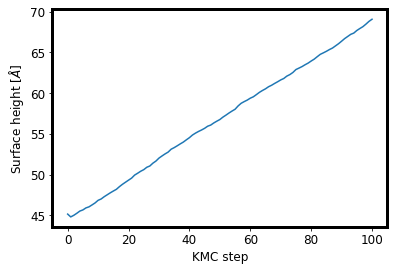

In [55]:
plt.plot(all_surface_heights)
plt.rcParams.update({'font.size': 12})
plt.xlabel('KMC step')
plt.ylabel('Surface height [$\AA$]')
plt.show()

Here we extract the KMC time from the run output.
When you run the mulskips code please store the screen output in the file log.txt:

`<path-of-the-compiled-code>/mulskips.e` | tee log.txt

In [56]:
def get_time(filename):
    with open (filename) as f:
        content = f.read().splitlines()
        line=content[0]
        splitline = line.split()
        time = float(splitline[3]) # Total number of atoms
    return time

In [57]:
kmc_time_list = []
for file in undercoordinated_atoms:
    filename = rundir+'/xyz/'+file
    time = get_time(filename)
    kmc_time_list.append(time)
#print(kmc_time_list)

Here we have to convert the KMC time in the real process time. That depends on the calibration strategy.
A reasonable rescale can be obtained with a constant jump frequency $\nu = 10^{-12}$ s.

In [58]:
nu = 1.0 # 1.0e-12 # jump frequency

In [59]:
time_list = [i * nu for i in kmc_time_list]

Here we plot the surface height as a z$^{\text{surf}}_{\text{ave}}$ as function of the procee time.

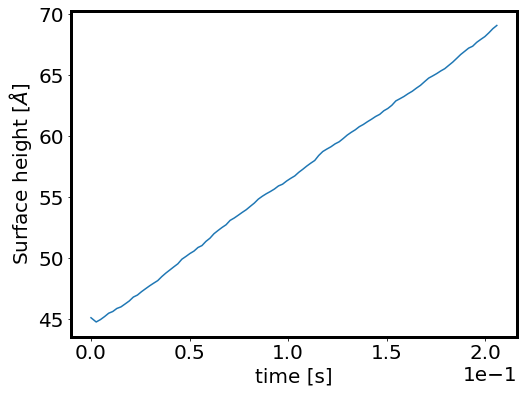

In [61]:
fig = plt.figure(figsize=(8,6))
plt.plot(time_list,all_surface_heights)
plt.rcParams.update({'font.size': 20})
plt.xlabel('time [s]')
plt.ylabel('Surface height [$\AA$]')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.savefig('figure-surface_height-time.pdf')
plt.show()

In [62]:
def get_growth_rate(time_list,all_surface_heights):
    gr = []
    dx = all_surface_heights[1] - all_surface_heights[0]
    dt = time_list[1] - time_list[0]
    curr_gr = dx / dt
    gr.append(curr_gr)
    for ind in range(len(time_list)-2):
        ind = ind+1
        dx = all_surface_heights[ind+1] - all_surface_heights[ind-1]
        dt = time_list[ind+1] - time_list[ind-1]
        curr_gr = dx / dt
        gr.append(curr_gr)
    dx = all_surface_heights[-1] - all_surface_heights[-2]
    dt = (time_list[-1] - time_list[-2]) # [s]
    curr_gr = (dx / dt)*3600*1e-4 # [micron/hour] 
    gr.append(curr_gr)
    return gr

In [63]:
growth_rate = get_growth_rate(time_list,all_surface_heights)

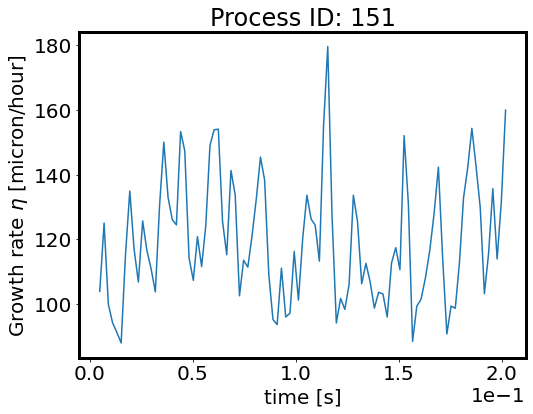

In [64]:
fig = plt.figure(figsize=(8,6))
plt.plot(time_list[2:-2],growth_rate[2:-2])
plt.rcParams.update({'font.size': 20})
plt.xlabel('time [s]')
plt.ylabel('Growth rate $\eta$ [micron/hour]')
plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
plt.title('Process ID: {}'.format(key))
plt.savefig('figure-growth_rate-time.pdf')
plt.show()

In [162]:
def get_ave_growth_rate(growth_rate):
    l=len(growth_rate)
    vect=growth_rate[5:l-5]
    ave=sum(vect)/len(vect)
    ave = '%.2f'% ave
    return ave

In [72]:
print('Average growth rate for Process ID {}: {} [micron/hour]'.format(key,get_ave_growth_rate(growth_rate)))

Average growth rate for Process ID 151: 119.20 [micron/hour]


In [117]:
print('Average growth rate for Process ID {}: {} [micron/hour]'.format(key,get_ave_growth_rate(growth_rate)))

Average growth rate for Process ID 148: 171.68 [micron/hour]


In [61]:
print('Average growth rate for Process ID {}: {} [micron/hour]'.format(key,get_ave_growth_rate(growth_rate)))

Average growth rate for Process ID 149: 176.42 [micron/hour]


In [112]:
print('Average growth rate for Process ID {}: {} [micron/hour]'.format(key,get_ave_growth_rate(growth_rate)))

Average growth rate for Process ID 152: 190.44 [micron/hour]


In [163]:
print('Average growth rate for Process ID {}: {} [micron/hour]'.format(key,get_ave_growth_rate(growth_rate)))

Average growth rate for Process ID 153: 198.10 [micron/hour]


In [247]:
    print('Experimental growth rates')
    for key in data_samples:
        print('Process ID {}: {} [micron/hour]'.format(key,data_samples[key]['Exp-Growth-Rate']))

Experimental growth rates
Process ID 151: 101 [micron/hour]
Process ID 148: 208 [micron/hour]
Process ID 149: 230 [micron/hour]
Process ID 152: 231 [micron/hour]
Process ID 153: 287 [micron/hour]
